# Building the Nemotron-CC Data Curation Pipeline Using Nemo Curator

This tutorial demonstrates how to use NeMo Curator to build the data curation pipeline used to create the the [Nemotron-CC dataset](https://arxiv.org/pdf/2412.02595). NeMo Curator is a Python library that consists of a collection of scalable data-mining modules for curating natural language processing (NLP) data for training large language models (LLMs). It consists of easy to use modules for data download, text extraction, language identification, quality filtering, and deduplication to build high-quality data curation pipelines at scale from massive uncurated web corpora.
## Nemotron-CC Curation Pipeline Components

- Common Crawl data download and extraction
- Language identification and filtering
- Exact and fuzzy deduplication
- Heuristic filtering and perplexity filtering
- Model based quality labeling
- Postprocessing

## Flowchart
<div style="text-align: center;">
<img src="images/nemotroncc_flowchart.png" alt="Nemotron-CC Diagram" width="500"/>
</div>

We will implement this flowchart in four individual phases as shown in the flowchart below.

In [ ]:
# !pip install mermaid-python
from mermaid import Mermaid

with open("viz/flowchart.txt", "r") as f:
    mermaid_code = f.read()

# Create and display the diagram with reduced size
Mermaid(mermaid_code)

## Prerequisites

### System Requirements
Here are the hardware settings used to create this notebook:

**GPU**: NVIDIA A100 80GiB.

**CUDA & Nvidia Drivers**: CUDA 12.2 with Driver 535.154.05

**OS**: ubuntu 22.04

### Getting the NeMo Framework Training Container
- Get access to the container via https://developer.nvidia.com/nemo-framework
- Set your Docker credentials 
    ```bash
    docker login nvcr.io

    Username: $oauthtoken
    Password: <Your NGC Key>
- Pull the NeMo Framework Training Container
    ```bash
    docker pull nvcr.io/nvidia/nemo:25.05.rc2
- Command to run the container
    ```bash
    docker run -it --gpus all -v ~/nemotron-cc:/workspace/nemotron-cc --name "nemotron-cc-tutorial" -p 8080:8080 nvcr.io/nvidia/nemo:25.02.rc5


## 0. Env Setup

In [1]:
%env CUDA_VISIBLE_DEVICES 1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import os

from nemo_curator.utils.distributed_utils import get_client, get_num_workers
from nemo_curator.utils.file_utils import separate_by_metadata
from nemo_curator.datasets import DocumentDataset
from viz.helper import DataSizeTracker

import pandas as pd
import time
import cudf
from dask.distributed import Client, LocalCluster
import jsonlines

/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [3]:
def pre_imports():
    import cudf 

def check_jsonl_file(file_dir):
    for file in os.listdir(file_dir):
        if "jsonl" not in file:
            continue
        with open(os.path.join(file_dir,file), "r", encoding="utf-8") as f:
            first_line = f.readline()
            print(first_line)
        break

def extract_lines_with_id(file_path,target_list):
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            if obj.get("id") in target_list:
                yield obj

In [4]:
cur_dir = os.getcwd()
print(cur_dir)
data_dir = f"{cur_dir}/data/"

/workspace/nemotron-cc


## 1. Data extraction and preprocessing

his code demonstrates downloading and processing Common Crawl snapshots. While we use two snapshots here, it can handle any number. The pipeline uses [justText](https://github.com/miso-belica/jusText) for text extraction and [fastText](https://fasttext.cc/docs/en/language-identification.html) for language detection.

### 1.1 Download and extraction

In [10]:
from nemo_curator.download import download_common_crawl, JusTextExtractor #, TrafilaturaExtractor

Initialize a CPU-based Dask cluster below. Adjust the number of workers and memory per worker based on your system's capabilities.

In [ ]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit="16GiB")
client

In [6]:
#Output
download_output_directory = os.path.join(data_dir,"cc_crawl", "data")

#Relevant parameters
start_snapshot = "2024-46"
end_snapshot = "2024-51"
language = "EN"
url_limit = 10 # Keep this low for testing purposes.

We will download and extract the dataset using `JusTextExtractor` (the default text extractor in NeMo Curator). While `TrafilaturaExtractor` is an alternative, ablation studies in the Nemotron-CC paper (Table 1) show `JusTextExtractor` produces better token yield.

# <img src="images/text_extractor_comparison.png" style="display: block; margin: 0 auto;">


In [ ]:
# Download and sample data
common_crawl = download_common_crawl(
    download_output_directory, 
    start_snapshot, 
    end_snapshot, 
    url_limit=url_limit,
    output_type="jsonl", # Default - "jsonl"
    algorithm=JusTextExtractor(), # Can be replaced with TrafilaturaExtractor()
).df().compute()

**[Optional]** Verify result.

In [11]:
# List all the file in the output directory.
!ls {download_output_directory}

CC-MAIN-20241201162023-20241201192023-00000.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00001.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00002.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00003.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00004.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00005.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00006.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00007.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00008.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00009.warc.gz.jsonl


In [13]:
check_jsonl_file(download_output_directory)

{"text":"Создаем узнаваемость\n\nпринимаем заказы по телефону200-19-00ежедневно с 09:00 до 18:00 (без выходных)или по почте zakaz@19.uz (круглосуточно)доставим чехлы бесплатно от 2-х до 4-х днейпо будням с 10:00 до 18:00 в пределах города","language":"RUSSIAN","url":"http:\/\/19.uz\/product.php?cat=00&id=26","warc_id":"327c8605-a7dc-4496-9a74-ac394d20bcbe","source_id":"crawl-data-CC-MAIN-2024-51-segments-1733066035857.0-warc-CC-MAIN-20241201162023-20241201192023-00002.warc.gz"}



In [ ]:
# Remove the temporary downloads directory that was used during processing
!rm -r {download_output_directory}/downloads

**[Optional]** Close the Dask cluster. You might encounter error such as `Caught signal 11`. It's OK, just rerun the cell again.

In [18]:
client.cluster.close()
client.shutdown()

Now that we have the dataset, it would be great to see how each step of the pipeline impacts the size of the dataset. Don't worry, we have a small helper function that tracks this for you.

In [9]:
input_dataset = DocumentDataset.read_json(download_output_directory, backend="pandas")
print("Length of downloaded and extracted dataset:", len(input_dataset))
tracker = DataSizeTracker(len(input_dataset))

Reading 10 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:412: UserWarning: If underlying JSONL data does not have a consistent schema, reading with blocksize will fail. Please use files_per_partition approach instead.
  warnings.warn(
/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:418: UserWarning: Pandas backend with blocksize cannot read multiple JSONL files into a single partition. Please use files_per_partition if blocksize exceeds average file size.
  warnings.warn(


Length of downloaded and extracted dataset: 157106


### 1.2 Language seperation and unicode fixing

In this section, we will be using a fastText language classification model to separate the Common Crawl dataset based on major languages, and fix the unicode in the documents. Detailed steps are:

1. Download fastText model for text language detection.
2. Construct a filter which uses the downloaded fastText model to produce a language label to each document. 
3. Separate each document by the language label. This will create sub-folders for each language under the output path and the documents under the same language will be output to a `.jsonl` file in the corresponding sub-folder.
4. Load `.jsonl` file in the folder of desirable language. In this example, the `EN` folder will be loaded.
5. Apply `UnicodeReformatter` to the data and output the result in .jsonl format. 



In [19]:
from nemo_curator import ScoreFilter, Modify
from nemo_curator.filters import FastTextLangId
from nemo_curator.modifiers import UnicodeReformatter

**[Optional]** Start a CPU based Dask cluster.

In [ ]:
# client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit="16GiB")
# client

Define parameters:

In [10]:
# Input path
multilingual_data_path = download_output_directory

# Output path
language_base_output_path = os.path.join(data_dir,"language_sep")
language_data_output_path = os.path.join(language_base_output_path,"data")
language_separated_output_path = os.path.join(language_data_output_path,"language")
lang_sep_cleaned_data_output_path = os.path.join(language_data_output_path,"cleaned")

# Fasttext model path
model_path = language_base_output_path

# Define desired language
target_language = "EN"

# Define key in output .jsonl files to store the language information
language_field = "language"

Download fastText model.

In [ ]:
!wget https://dl.fbaipublicfiles.com/fastText/supervised-models/lid.176.bin -P {model_path}

Apply fastText model to separate documents by their languages.

In [ ]:
t0 = time.time()

# Load dataset 
multilingual_dataset = DocumentDataset.read_json(multilingual_data_path, blocksize="64MiB", add_filename=True)

#Define Language separation pipeline
lang_filter = FastTextLangId(os.path.join(model_path,"lid.176.bin"))
language_id_pipeline = ScoreFilter(lang_filter, score_field=language_field, score_type="object")
filtered_dataset = language_id_pipeline(multilingual_dataset)

# The language separation pipeline will produce a result looks like ["EN",0.96873], we only want to keep the "EN" label and drop the detailed classifier score
filtered_dataset.df[language_field] = filtered_dataset.df[language_field].apply(lambda score: score[1],meta = (language_field, "object"))

# Split the dataset to corresponding language sub-folders
language_stats = separate_by_metadata(filtered_dataset.df, language_separated_output_path, metadata_field=language_field).compute()

print(f"Time taken for splitting language:{time.time()-t0}")

Load `UnicodeReformatter` to reformat any unicode appeared in the desired language dataset:

In [ ]:
t0 = time.time()

# Read the language specific data and fix the unicode in it
lang_data_path = os.path.join(language_separated_output_path, target_language)
lang_data = DocumentDataset.read_json(lang_data_path, blocksize="64MiB", add_filename=True)

cleaner = Modify(UnicodeReformatter())
cleaned_data = cleaner(lang_data)

# Write the cleaned_data
cleaned_data.to_json(lang_sep_cleaned_data_output_path, write_to_filename=True)

print(f"Time taken for fixing unicode:{time.time()-t0}")

In [17]:
# List all the file in the output directory.
! ls {lang_sep_cleaned_data_output_path}

CC-MAIN-20241201162023-20241201192023-00000.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00001.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00002.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00003.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00004.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00005.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00006.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00007.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00008.warc.gz.jsonl
CC-MAIN-20241201162023-20241201192023-00009.warc.gz.jsonl


Verify the result.

In [18]:
check_jsonl_file(os.path.join(language_separated_output_path,"EN"))

{"language":"EN","source_id":"crawl-data-CC-MAIN-2024-51-segments-1733066035857.0-warc-CC-MAIN-20241201162023-20241201192023-00002.warc.gz","text":"Cook pasta according to package instructions. Saute ham in oil to brown it a bit and then remove from pan and set aside. Cook onion 4 minutes then add mushrooms and continue cooking another 4 minutes. Mix in flour, rosemary and pepper then gradually add milk and bring to a boil and cook 2 minutes to thicken it up. Then reduce heat and add peas and sour cream and cook 2 minutes. Mix with the drained pasta and ham and heat through.\n\nJoin us on Facebook and Get Notified When New Recipes Are Posted\n\nAbout 400 Calories or Less\n\nWhat's a foodie to do when she passes the 40 mark and her metabolism comes to a screeching halt? (hint...denial did not work !) So I've put together a collection of everyday meals that are simple to make, under 400 calories, yet so savory and delicious that you won't miss your old favorites and standbys. I've tested

In [11]:
lang_id_dataset = DocumentDataset.read_json(os.path.join(language_separated_output_path,"EN"), backend="pandas")
tracker.record_size("Language Identification", len(lang_id_dataset))
tracker.print_summary()

Reading 10 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:412: UserWarning: If underlying JSONL data does not have a consistent schema, reading with blocksize will fail. Please use files_per_partition approach instead.
  warnings.warn(
/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:418: UserWarning: Pandas backend with blocksize cannot read multiple JSONL files into a single partition. Please use files_per_partition if blocksize exceeds average file size.
  warnings.warn(


Data Processing Summary:
Original Size: 157106
Final Size: 74194
Total Filtered: 82912 (52.77% of original)

Stage-wise Filtering:
  Stage: Language Identification, Result Size: 74194, Filtered Out: 82912 (52.77% of original)


**[Optional]** Close the Dask cluster.

In [ ]:
# client.cluster.close()
# client.shutdown()

## 2. Data deduplication and quality filtering
This section covers deduplication of data using both exact and fuzzy matching approaches.

Exact deduplication works by generating a unique hash (like MD5) for each document's text. Documents that produce identical hashes contain identical content. We identify these duplicates using the `ExactDuplicates()` function, which accepts these parameters:
- `id_field`: Field containing the document identifier
- `text_field`: Field containing the document text content
- `hash_method`: Algorithm for generating hashes (defaults to MD5)
- `cache_dir`: Optional directory to save IDs of duplicate documents

To speed up the deduplication process (both exact and fuzzy), we'll utilize GPU acceleration via a Dask cluster


To enable effective deduplication, we need to first ensure unique document identification. Standard fields like `source_id` in Common Crawl data may not provide sufficient uniqueness. We'll solve this by creating unique IDs with a `<prefix>_<id>` format using the NeMo Curator `AddID()` function. This approach helps track document origins across multiple datasets during deduplication. Key parameters for `AddID()` include:
- `id_field`: Name of the new ID field to add/replace in the JSON
- `id_prefix`: Text prefix for generated IDs (like "doc_id") 
- `start_index`: Starting number for sequential IDs. Using 0 helps with tracking, while `None` enables faster unordered IDs

### 2.1 Preparation

In [11]:
from nemo_curator import AddId

**[Optional]** If there is no running Dask cluster, start CPU based Dask cluster.

In [ ]:
# cluster = LocalCluster(n_workers=10, processes=True, memory_limit="16GB")
# client = Client(cluster)

In [13]:
#Input
add_id_input_data_dir = lang_sep_cleaned_data_output_path

#Output
added_id_output_path = os.path.join(data_dir,"add_id/cleaned")

#Format of output ID will be <prefix>_<id>, Define prefix here
add_ID_id_prefix="EN_CC"

In [ ]:
t0 = time.time()
# Read input files
dataset = DocumentDataset.read_json(add_id_input_data_dir,add_filename=True)

# Run AddID() on the input dataset
add_id = AddId(id_field="id",id_prefix=add_ID_id_prefix,start_index=0)
id_dataset = add_id(dataset)

#Output files
id_dataset.to_json(added_id_output_path, write_to_filename=True)

print(f"Time taken for add ID:{time.time()-t0}")

In [21]:
check_jsonl_file(added_id_output_path)

{"language":"EN","source_id":"crawl-data-CC-MAIN-2024-51-segments-1733066035857.0-warc-CC-MAIN-20241201162023-20241201192023-00002.warc.gz","text":"Cook pasta according to package instructions. Saute ham in oil to brown it a bit and then remove from pan and set aside. Cook onion 4 minutes then add mushrooms and continue cooking another 4 minutes. Mix in flour, rosemary and pepper then gradually add milk and bring to a boil and cook 2 minutes to thicken it up. Then reduce heat and add peas and sour cream and cook 2 minutes. Mix with the drained pasta and ham and heat through.\n\nJoin us on Facebook and Get Notified When New Recipes Are Posted\n\nAbout 400 Calories or Less\n\nWhat's a foodie to do when she passes the 40 mark and her metabolism comes to a screeching halt? (hint...denial did not work !) So I've put together a collection of everyday meals that are simple to make, under 400 calories, yet so savory and delicious that you won't miss your old favorites and standbys. I've tested

Close Dask cluster. This cell needs to be run as we are starting a new GPU Dask cluster in the following task.

In [ ]:
# client.cluster.close()
# client.shutdown()

### 2.2 Exact deduplication

Next, we will perform exact deduplication to remove duplicate documents.

In [12]:
from nemo_curator.modules import ExactDuplicates

Start a GPU based Dask cluster. Since GPU based Dask cluster involves setting several arguments, we will use the `get_client()` wrapper function to quickly set up. 

In [ ]:
client = get_client(cluster_type="gpu", set_torch_to_use_rmm=False)
print(f"Number of dask worker:{get_num_workers(client)}")
client.run(pre_imports)
client

If you encounter the following error
`get_client() missing 1 required positional argument: "args"`:

This is probably because the `nemo_curator` library is not updated to the newer version. Please run the following line in the terminal, following instruction in our [GitHub](https://github.com/nicoleeeluo/NeMo-Curator/tree/main) repo, and restart the notebook. Intermediate result of the previous section has been saved to local, you can start from this section after updating.

In [ ]:
#pip install --extra-index-url https://pypi.nvidia.com ".[cuda12x]"

Define parameters:

In [14]:
#Input
exact_dedup_input_dataset_dir = added_id_output_path

#Output
exact_dedup_base_output_path = os.path.join(data_dir,"exact_deduplication")
exact_dedup_log_dir = os.path.join(exact_dedup_base_output_path,"log")
exact_duplicates_dir = os.path.join(exact_dedup_base_output_path,"duplicates")
exact_dedup_output_dir = os.path.join(exact_dedup_base_output_path,"data")

#Parameters for ExactDuplicates()
exact_dedup_dataset_id_field = "id"
exact_dedup_dataset_text_field = "text"

!mkdir -p {exact_dedup_log_dir}
!mkdir -p {exact_dedup_output_dir}


In [ ]:
t0 = time.time()
# Read input dataset
input_dataset = DocumentDataset.read_json(exact_dedup_input_dataset_dir, backend="cudf")

#Run exact deduplication to the input
exact_dup = ExactDuplicates(
    logger=exact_dedup_log_dir,
    id_field=exact_dedup_dataset_id_field,
    text_field=exact_dedup_dataset_text_field,
    hash_method="md5",
    cache_dir=exact_duplicates_dir # Duplicated document ID list is output to the cache_dir
)
duplicates = exact_dup(dataset=input_dataset)
print(f"Number of exact duplicated file:{len(duplicates)}")
print(f"Time taken for exact duplicate:{time.time()-t0}")

**[Optional]** Verify the output duplicated ID. We can group by the `_hashes` to get the list of duplicated documents having the same _hashes.

In [19]:
exact_dedup_res = pd.read_parquet(os.path.join(exact_duplicates_dir,"_exact_duplicates.parquet"))
print(f"Number of exact duplicated document:{len(exact_dedup_res)}")
duplicated_list = exact_dedup_res.groupby("_hashes")["id"].agg(list).reset_index().head()
duplicated_list

Number of exact duplicated document:8937


,_hashes,id
0,0016fa4543e1d6913cf7ebebe9b2d2f9,"[EN_CC-0000014715, EN_CC-0000044369]"
1,00246b1ca1ac91e27c0e9d5806f6fbf2,"[EN_CC-0000022205, EN_CC-0000036878]"
2,00362d462942216e6aa8fcc583c2ca81,"[EN_CC-0000051215, EN_CC-0000066095]"
3,0090d246b4f44804647d2601964a2932,"[EN_CC-0000014830, EN_CC-0000059283, EN_CC-000..."
4,009b7a3794bce22726148ac37b74b92b,"[EN_CC-0000059195, EN_CC-0000059196, EN_CC-000..."


Remove duplicates from original dataset.

In [ ]:
result = exact_dup.remove(input_dataset, duplicates)
result.to_parquet(exact_dedup_output_dir, write_to_filename=True)

In [15]:
res = pd.read_parquet(exact_dedup_output_dir)
tracker.record_size("Exact Deduplication", len(res))
tracker.print_summary()

Data Processing Summary:
Original Size: 157106
Final Size: 67907
Total Filtered: 89199 (56.78% of original)

Stage-wise Filtering:
  Stage: Language Identification, Result Size: 74194, Filtered Out: 82912 (52.77% of original)
  Stage: Exact Deduplication, Result Size: 67907, Filtered Out: 6287 (4.00% of original)


**[Optional]** You might choose to close Dask cluster here

In [27]:
# client.cluster.close()
# client.shutdown()

### 2.3 Fuzzy deduplication

Now, let's perform Fuzzy Deduplication.

Fuzzy deduplication involves 3 to 5 intermediate steps to generate duplicates. Please refer to [the documentation](https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/gpudeduplication.html) for details.

Fuzzy deduplication in this example is a GPU implementation of MinhashLSH algorithm. This algorithm measures similarity based on statistics but not semantic meanings of text. There are a few concepts to be introduced before heading into fuzzy deduplication.

This algorithm has following steps in a high-level:
1. Compute minhashes for each document.
2. Run Locality Sensitive Hashing (LSH) based on the minhash values, which further assigns buckets to each document. Each document will be assigned to multiple buckets. Documents within the same bucket are deemed to be similar.
3. Based on the buckets and Jaccard values between documents (if computed), transform documents across buckets (deemed similar) into a graph and run the connected components algorithm. For a group of connected components in the graph, they are the final similar document groups and the IDs within each groups will be output for duplicate removal.
More detailed explanation please refer to [the documentation](https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/gpudeduplication.html#fuzzy-deduplication).

In this section, we will use the fuzzy deduplication wrapper offered by NeMo Curator instead of running each step individually.

If there is not running Dask cluster, start a GPU Dask cluster here.

In [ ]:
client = get_client(cluster_type="gpu", set_torch_to_use_rmm=False)
print(f"Number of dask worker:{get_num_workers(client)}")
client.run(pre_imports)
client

In [38]:
from nemo_curator import FuzzyDuplicates, FuzzyDuplicatesConfig

In [18]:
#Input
fuzzy_dedup_data_path = exact_dedup_output_dir
#Output
fuzzy_dedup_base_output_path = os.path.join(data_dir,"fuzzy_deduplication")
fuzzy_dedup_log_dir = os.path.join(fuzzy_dedup_base_output_path,"log")
fuzzy_dedup_no_false_positive_cache_dir = os.path.join(fuzzy_dedup_base_output_path,"cache_nofp")
fuzzy_dedup_false_positive_cache_dir = os.path.join(fuzzy_dedup_base_output_path,"cache_fp")
fuzzy_duplicates_dir = os.path.join(fuzzy_dedup_base_output_path,"duplicates")
fuzzy_dedup_output_dir = os.path.join(fuzzy_dedup_base_output_path,"data")

#Specify dataset name
dataset_name = "EN_CC"

#Relevant parameters
id_field = "id"
text_field = "text"
filetype = "parquet"

!mkdir -p {fuzzy_dedup_base_output_path}
!mkdir -p {fuzzy_dedup_log_dir}
# Clear cache folders
if os.path.exists(fuzzy_dedup_no_false_positive_cache_dir):
    !rm -rf {fuzzy_dedup_no_false_positive_cache_dir}/*
!mkdir -p {fuzzy_dedup_no_false_positive_cache_dir}

if os.path.exists(fuzzy_dedup_false_positive_cache_dir):
    !rm -rf {fuzzy_dedup_false_positive_cache_dir}/*
!mkdir -p {fuzzy_dedup_false_positive_cache_dir}
!mkdir -p {fuzzy_duplicates_dir}
!mkdir -p {fuzzy_dedup_output_dir}

In [ ]:
t0 = time.time()

input_dataset = DocumentDataset.read_parquet(fuzzy_dedup_data_path, backend="cudf")

fuzzy_dedup_config = FuzzyDuplicatesConfig(
    cache_dir=fuzzy_dedup_no_false_positive_cache_dir,
    id_field=id_field,
    text_field=text_field,
    seed=10,
    char_ngrams=24,
    num_buckets=20,
    hashes_per_bucket=13,
    use_64_bit_hash=False,
    buckets_per_shuffle=5,
    false_positive_check=False,
)

fuzzy_dup = FuzzyDuplicates(logger=fuzzy_dedup_log_dir, config=fuzzy_dedup_config)
duplicates = fuzzy_dup(dataset=input_dataset)
print(f"Time taken for Fuzzy Deduplication: {time.time()-t0} s")

In [41]:
duplicates.to_parquet(fuzzy_duplicates_dir, write_to_filename=False)
fuzzy_dedup_res = pd.read_parquet(fuzzy_duplicates_dir)
fuzzy_dedup_res.head()

,group,id
0,1216,EN_CC-0000021705
1,1575,EN_CC-0000023135
2,1216,EN_CC-0000023964
3,1576,EN_CC-0000036587
4,1216,EN_CC-0000025421


This section removes duplicate documents identified by exact and fuzzy deduplication. It loads the deduplication results and the input dataset, then removes the identified duplicates using DataFrame operations.

We will first process the result of exact deduplication. Since result of exact deduplication contains original ID used in input dataset, it is more straightforward to deal with.

In [ ]:
result = fuzzy_dup.remove(input_dataset, duplicates)
result.to_parquet(fuzzy_dedup_output_dir, write_to_filename=True)

Verify the result of duplicate removal. We can see that the number of documents in resultant dataset is less than the original dataset.

In [19]:
res = pd.read_parquet(fuzzy_dedup_output_dir)
tracker.record_size("Fuzzy Deduplication", len(res))
tracker.print_summary()

Data Processing Summary:
Original Size: 157106
Final Size: 64373
Total Filtered: 92733 (59.03% of original)

Stage-wise Filtering:
  Stage: Language Identification, Result Size: 74194, Filtered Out: 82912 (52.77% of original)
  Stage: Exact Deduplication, Result Size: 67907, Filtered Out: 6287 (4.00% of original)
  Stage: Fuzzy Deduplication, Result Size: 64373, Filtered Out: 3534 (2.25% of original)


Close the GPU Dask Cluster. You might encounter error such as `Caught signal 11`. It's OK, just rerun the cell again.

In [45]:
client.cluster.close()
client.shutdown()

### [Optional] Exact substring deduplication

We can optionally perform exact substring deduplication as described in the paper. Since this module is not yet available in NeMo Curator, we'll use Google's deduplicate-text-dataset ([GitHub repository](https://github.com/google-research/deduplicate-text-datasets/tree/master)) library instead.

**NOTE: The code in this section serves as a reference implementation. The library requires input data to be preprocessed into a specific binary format for its Rust-based scripts. While we provide helper functions for preprocessing and postprocessing, the complete pipeline remains untested. Please use this code as a starting point and adapt it to your specific needs.**

Exact substring deduplication is a technique that identifies and removes repeated text sequences from a dataset. It works by:

1. Preprocessing and shrinking the data with a tokenizer and by converting it to binary format.
2. Creating a suffix array of the entire dataset.
3. Scanning through the suffix array to identify duplicates. Since suffix arrays are sorted alphabetically, two indices that are adjacent to each other and match up to a given threshold are considered substring duplicates.
4. Providing parallel processing capabilities across multiple CPU cores.
5. Outputting detailed information about duplicate locations and cluster sizes.

For more details, see the [README](https://github.com/google-research/deduplicate-text-datasets/tree/master?tab=readme-ov-file#finding-all-repeated-substrings-within-a-document).


This tool is built on Rust and requires a Rust compiler to run.

In [ ]:
# Install Rust compiler using rustup (recommended to run in terminal)
!curl --proto "=https" --tlsv1.2 -sSf https://sh.rustup.rs | sh
# Clone the repository
!git clone https://github.com/google-research/deduplicate-text-datasets.git
# Build the project
!cd deduplicate-text-datasets && cargo build

In [32]:

substring_dedup_input_dir = fuzzy_dedup_output_dir
substring_dedup_base_dir = os.path.join(data_dir, "substring_deduplication")
substring_dedup_intermediate_dir = os.path.join(substring_dedup_base_dir, "intermediate")
substring_dedup_duplicates_dir = os.path.join(substring_dedup_base_dir, "duplicates")
substring_dedup_output_dir = os.path.join(substring_dedup_base_dir, "output")

!mkdir -p {substring_dedup_base_dir}
!mkdir -p {substring_dedup_output_dir}
!mkdir -p {substring_dedup_intermediate_dir}
!mkdir -p {substring_dedup_duplicates_dir}

intermediate_file = os.path.join(substring_dedup_intermediate_dir, "encc.bin")
intermediate_sizes = os.path.join(substring_dedup_intermediate_dir, "encc_size.bin")

In [33]:
import struct
import numpy as np
import crossfit as cf
from crossfit import op
from tqdm import tqdm

# Create output directory and open output file
ftxt = open(intermediate_file, "wb")
fsize = open(intermediate_sizes, "wb")

dataset = DocumentDataset.read_parquet(substring_dedup_input_dir, backend="cudf")

sizes = [0]  # Track cumulative sizes of examples
text_field = "text"
id_field = "id"

# Tokenize dataset if your dataset is large
# Optionally tokenize your dataset if it's larget
# model = cf.HFModel("microsoft/deberta-v3-base")
# tokenizer = op.Tokenizer(model, cols=[text_field], tokenizer_type="spm")
# ddf = dataset.df
# results = tokenizer(ddf)
# results = results.compute()

# The tokenized results contain "input_ids" and "attention_mask" columns - use input_ids as the new text field for further processing
# dataset.df = ddf.join(results)
# key = "input_ids"

# Process and write examples to file
dataset_pd = dataset.to_pandas()

# ASCII 255 (0xFF) is the non-breaking space character
pre_sep = bytes([255, 255])  # Non-breaking space sequence
post_sep = bytes([255, 255])  # Non-breaking space sequence

# Pre-allocate sizes list with initial capacity based on dataset size
sizes = np.zeros(len(dataset_pd) + 1, dtype=np.uint64)
current_size = 0

# Process examples in batches for better performance
batch_size = 1000
for i in tqdm(range(0, len(dataset_pd), batch_size), desc="Generating compatible dataset for deduplicate-text-datasets repository"):
    batch = dataset_pd.iloc[i:i+batch_size]
    
    # Process each row in the batch
    for _, row in batch.iterrows():
        # Encode both text and ID to bytes once
        text_bytes = row[text_field].encode("utf-8")
        id_bytes = row[id_field].encode("utf-8")
        # Construct the line with pre-separator, ID, post-separator, and text
        next_line = pre_sep + id_bytes + post_sep + text_bytes
        # Write the line and update size tracking
        ftxt.write(next_line)
        current_size += len(next_line)
        sizes[i+1] = current_size

# Write size information to a separate file
fsize.write(sizes.tobytes())
fsize.close()

Reading 1 files with blocksize='1gb' / files_per_partition=None


/opt/NeMo-Curator/nemo_curator/utils/distributed_utils.py:450: UserWarning: If underlying Parquet data does not have consistent schema, reading with blocksize will fail. Please update underlying RAPIDS package to version 25.02 or higher, or use files_per_partition approach instead.
  warnings.warn(
Generating compatible dataset for deduplicate-text-datasets repository: 100%|██████████| 65/65 [00:03<00:00, 17.18it/s]


Run substring deduplication to identify and remove duplicate text segments.

**Note: These commands are based on the deduplicate-text-datasets repository [documentation](https://github.com/google-research/deduplicate-text-datasets/tree/master). 
Please verify the commands and parameters before execution.**

In [ ]:
# Run self-similarity detection
!cd deduplicate-text-datasets && cargo run self-similar --data-file ${intermediate_file} --length-threshold 100 --cache-dir ${substring_dedup_duplicates_dir} --num-threads 8
# Run collection step
!cd deduplicate-text-datasets && cargo run collect --data-file ${intermediate_file} --cache-dir ${substring_dedup_duplicates_dir} --length-threshold 100 > ${substring_dedup_output_dir}

After running the substring deduplication, you'll need to convert the results back to a structured format (JSONL or parquet).
Below is a reference implementation for post-processing the deduplicated dataset. While not fully tested, it demonstrates the key concepts and workflow for handling deduplication results and converting them back to structured formats.

In [ ]:
import numpy as np
import os
import shutil
import json
from collections import defaultdict
import pandas as pd
import multiprocessing as mp

def process_row(args):
    """Process a single row of data"""
    idx, row = args
    new_row = {
        "id": row["id"],
        "text": row["text"],
        # add other columns as needed
    }
    
    if idx in remove_ex:
        for start, end in remove_ex[idx][::-1]:
            new_row["text"] = new_row["text"][:start] + new_row["text"][end:]
    
    return new_row

def process_dataset(input_path, output_path, remove_file, suffixarray_dir, dataset_name, split_name):
    """Process the dataset using pandas"""
    # Read the input dataset
    df = pd.read_parquet(input_path)
    
    # Read removal information
    remove = []
    with open(remove_file) as fin:
        for line in fin:
            if "out" in line:
                break
        for line in fin:
            remove.append(list(map(int, line.split())))
    
    # Read size information
    size_file = os.path.join(suffixarray_dir, f"{dataset_name}.{split_name}.size")
    sizes = np.frombuffer(open(size_file, "rb").read(), dtype=np.uint64)
    
    # Process removal information
    remove_ex = defaultdict(list)
    ptr = 0
    for i, byte_start in enumerate(sizes[:-1]):
        byte_end = sizes[i+1]
        while ptr < len(remove) and byte_start <= remove[ptr][0] < byte_end:
            assert remove[ptr][1] < byte_end+6
            remove_ex[i].append((
                max(int(remove[ptr][0] - byte_start - 6), 0),
                min(int(remove[ptr][1] - byte_start), byte_end-byte_start)
            ))
            ptr += 1
    
    # Process the dataset in parallel
    with mp.Pool(mp.cpu_count()) as pool:
        processed_rows = pool.map(process_row, enumerate(df["text"]))
    
    # Create new dataframe with processed rows
    processed_df = pd.DataFrame(processed_rows)
    
    # Save processed dataset
    processed_df.to_parquet(output_path)

# Example usage
process_dataset(
    "path/to/input",
    "path/to/output",
    "path/to/remove/file",
    "path/to/suffixarray/dir",
    "dataset_name",
    "split_name"
)

### 2.4 Heuristic and Perplexity Fitlering

In this section, we will apply multiple heuristic filters to the dataset, record the heuristic score for documents, and remove documents according to their scores. For each heuristic filter, the filter calculates a quality score based on user defined heuristics/algorithms and classifies documents into high quality documents or low quality documents if the quality score is above the user defined threshold.

For implementation details and descriptions of each heuristic filter, please refer to `./NeMo-Curator/nemo-curator/filters/heuristics_filter.py`. For customized heuristic filter implementations, user shall follow the sample implementations, write customized filters and update the YAML files accordingly.

In [16]:
from nemo_curator.utils.config_utils import build_filter_pipeline
from nemo_curator import Score, ScoreFilter

Create a CPU Dask Cluster.

In [ ]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit="16GiB")
client

Define some helper functions.

In [46]:
def get_dataframe_complement(original_df, filtered_df):
    def partition_complement(part_original_df, partition_info=None):
        if not partition_info:
            return part_original_df
        part_filtered_df = filtered_df.get_partition(partition_info["number"])
        complement_mask = ~part_original_df.index.isin(part_filtered_df.index.persist())
        complement_df = part_original_df[complement_mask]
        return complement_df

    return original_df.map_partitions(partition_complement)

def write_scores(df, output_dir):
    for column in df.columns:
        output_path = os.path.join(output_dir, f"{column}.txt")
        df[column].to_csv(output_path, single_file=True, encoding="utf-8", header=False, index=False, mode="a")

def get_score_fields(pipeline):
    score_fields = []
    for nc_module in pipeline.modules:
        if isinstance(nc_module, Score) or isinstance(nc_module, ScoreFilter):
            if nc_module.score_field:
                score_fields.append(nc_module.score_field)
    return score_fields

Define parameters:

In [20]:
#Input
HF_input_data_dir = fuzzy_dedup_output_dir
input_file_type = "parquet"
batch_size = 1

#Output
HF_base_output_path = os.path.join(data_dir,"heuristic_filtering")
kept_document_dir =  os.path.join(HF_base_output_path,"data","hq.parquet")
removed_document_dir =  os.path.join(HF_base_output_path,"data","lq.parquet")
output_document_score_dir =  os.path.join(HF_base_output_path,"data","score")
output_file_type = "parquet"

#Relevant parameters
filter_config_file = "./config/heuristic_filter_en.yaml"
input_id_field = "id"

!mkdir -p {kept_document_dir}
!mkdir -p {removed_document_dir}
!mkdir -p {output_document_score_dir}

Run heuristic filtering.

In [ ]:
t0 = time.time()

#Load filters from config
filter_pipeline = build_filter_pipeline(filter_config_file)
score_fields = get_score_fields(filter_pipeline)

# Load dataset
dataset = DocumentDataset.read_parquet(HF_input_data_dir, files_per_partition=1, blocksize=None, backend="pandas", add_filename=True)

filtered_dataset = filter_pipeline(dataset)

# Write scores of retained doucment to separate directory
output_df = filtered_dataset.df[[input_id_field, *score_fields]]
write_scores(output_df, output_document_score_dir)

# Remove scores from dataset df
filtered_dataset = DocumentDataset(filtered_dataset.df.drop(columns=score_fields))

# Output filtered dataset
filtered_dataset.to_parquet(kept_document_dir, write_to_filename=True)

print(f"Time taken for Heuristic filtering: {time.time()-t0} s")

**[Optional]** Verify the result.

In [21]:
res = pd.read_parquet(kept_document_dir)
res.head()

,id,language,source_id,text,url,warc_id
0,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e
1,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d
2,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90
3,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f
4,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362


In [22]:
tracker.record_size("Heuristic Filtering", len(res))
tracker.print_summary()

Data Processing Summary:
Original Size: 157106
Final Size: 47107
Total Filtered: 109999 (70.02% of original)

Stage-wise Filtering:
  Stage: Language Identification, Result Size: 74194, Filtered Out: 82912 (52.77% of original)
  Stage: Exact Deduplication, Result Size: 67907, Filtered Out: 6287 (4.00% of original)
  Stage: Fuzzy Deduplication, Result Size: 64373, Filtered Out: 3534 (2.25% of original)
  Stage: Heuristic Filtering, Result Size: 47107, Filtered Out: 17266 (10.99% of original)


Close the CPU Dask Cluster

In [50]:
client.cluster.close()
client.shutdown()

Now, let's perform perplexity filtering using a KenLM model trained on wikipedia data. NeMo Curator does not support KenLM filtering out of the box, instead we will use pre-trained KenLM models hosted on [HuggingFace](https://huggingface.co/edugp/kenlm/tree/main/wikipedia) to generate perplexity scores for every document and filter based on a threshold.

In [ ]:
# Install dependencies
!pip install sentencepiece https://github.com/kpu/kenlm/archive/master.zip

In [21]:
models_dir = os.path.join(cur_dir, "models", "wikipedia")
os.makedirs(models_dir, exist_ok=True)
# Download KenLM pre-trained models
# !wget https://huggingface.co/edugp/kenlm/blob/main/wikipedia/en.arpa.bin -P {models_dir}
# !wget https://huggingface.co/edugp/kenlm/blob/main/wikipedia/en.sp.model -P {models_dir}
# !wget https://huggingface.co/edugp/kenlm/blob/main/wikipedia/en.sp.vocab -P {models_dir}

In [38]:
from nemo_curator.filters.doc_filter import DocumentFilter
from kenlm_utility import KenlmModel

class PerplexityFilter(DocumentFilter):

  def __init__(self, threshold):
    self._kenlm_model = KenlmModel(model_path=models_dir, language="en")
    self._threshold = threshold

  def score_document(self, text: str):
    return self._kenlm_model.get_perplexity(text, normalize=True)

  def keep_document(self, score: int):
    return score <= self._threshold

In [ ]:
client = get_client(cluster_type="cpu", n_workers=10, processes=True, memory_limit="16GiB")
client

In [23]:
#Input
PF_input_data_dir = os.path.join("/workspace/nemotron-cc/data/heuristic_filtering/data/hq.parquet","result.parquet")
input_file_type = "parquet"
batch_size = 1

#Output
PF_base_output_path = os.path.join(data_dir,"perplexity_filtering")
kept_document_dir =  os.path.join(PF_base_output_path,"data","hq.parquet")
removed_document_dir =  os.path.join(PF_base_output_path,"data","lq.parquet")
output_document_score_dir =  os.path.join(PF_base_output_path,"data","score")
output_file_type = "parquet"

#Relevant parameters
input_id_field = "id"
# Adjust the threshold to control the strictness of filtering; higher values are more lenient, lower values are more strict.
# Experiment to find the optimal balance between data reduction and quality retention.
threshold = 100000.00

!mkdir -p {kept_document_dir}
!mkdir -p {removed_document_dir}
!mkdir -p {output_document_score_dir}

In [61]:
t0 = time.time()

# Load dataset
dataset = DocumentDataset.read_parquet(PF_input_data_dir, files_per_partition=1, blocksize=None, backend="pandas", add_filename=True)

perplexity_filter = ScoreFilter(
                PerplexityFilter(threshold=100000.00),
                text_field="text",
                score_field="perplexity_score",
            )

filtered_dataset = perplexity_filter(dataset)

# Write scores of retained doucment to separate directory
output_df = filtered_dataset.df[[input_id_field, perplexity_filter.score_field]]
write_scores(output_df, output_document_score_dir)

# Remove scores from dataset df
filtered_dataset = DocumentDataset(filtered_dataset.df.drop(columns=perplexity_filter.score_field))

# Output filtered dataset
filtered_dataset.to_parquet(kept_document_dir, write_to_filename=True)

print(f"Time taken for Perplexity filtering: {time.time()-t0} s")

Reading 1 files with blocksize=None / files_per_partition=1


/usr/local/lib/python3.12/dist-packages/dask_expr/_collection.py:4376: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('text', 'float64'))

  warnings.warn(meta_warning(meta))


Writing to disk complete for 1 partition(s)
Time taken for Perplexity filtering: 283.00895953178406 s


In [24]:
res = pd.read_parquet(kept_document_dir)
tracker.record_size("Perplexity filtering", len(res))
tracker.print_summary()

Data Processing Summary:
Original Size: 157106
Final Size: 47107
Total Filtered: 109999 (70.02% of original)

Stage-wise Filtering:
  Stage: Language Identification, Result Size: 74194, Filtered Out: 82912 (52.77% of original)
  Stage: Exact Deduplication, Result Size: 67907, Filtered Out: 6287 (4.00% of original)
  Stage: Fuzzy Deduplication, Result Size: 64373, Filtered Out: 3534 (2.25% of original)
  Stage: Heuristic Filtering, Result Size: 47107, Filtered Out: 17266 (10.99% of original)
  Stage: Perplexity filtering, Result Size: 47107, Filtered Out: 0 (0.00% of original)


As you may have noticed, perplexity filtering did not further filter any documents. This is likely because the chosen threshold was too lenient for our already filtered dataset. We can further verify this by plotting a Gaussian curve of all the scores we saved during our filtering process. The plot reveals that the perplexity scores for nearly all texts are below 6000, with the majority falling below 1000. This indicates that the input dataset to this filter was already of relatively high quality. Generally, KenLM perplexity scores below 2000 are considered good, while scores above approximately 10000 are considered poor.

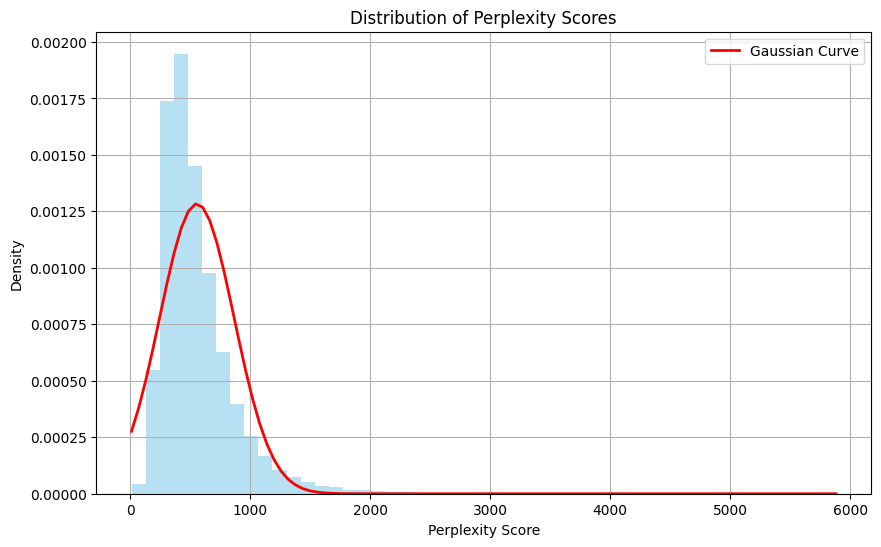

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load perplexity scores from the text file
file_path = os.path.join(output_document_score_dir, "perplexity_scores.txt")
try:
    with open(file_path, "r") as f:
        perplexity_scores = [float(line.strip()) for line in f]
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    perplexity_scores = []  # Assign an empty list to avoid errors later
except ValueError:
    print(f"Error: Could not convert lines in {file_path} to float. Check the file format.")
    perplexity_scores = []

if perplexity_scores:
    # Create a pandas Series from the perplexity scores
    perplexity_series = pd.Series(perplexity_scores)

    # Plot the distribution as a histogram with a Gaussian curve overlay
    plt.figure(figsize=(10, 6))
    perplexity_series.hist(bins=50, density=True, alpha=0.6, color="skyblue")

    # Overlay a Gaussian curve
    mu = perplexity_series.mean()
    sigma = perplexity_series.std()
    x = np.linspace(perplexity_series.min(), perplexity_series.max(), 100)
    plt.plot(x, (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2), color="red", linewidth=2, label='Gaussian Curve')

    plt.title('Distribution of Perplexity Scores')
    plt.xlabel('Perplexity Score')
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No perplexity scores to plot.")


In [43]:
client.cluster.close()
client.shutdown()

Let's analyze and visualize how the dataset size changed after applying each filtering step in our pipeline.

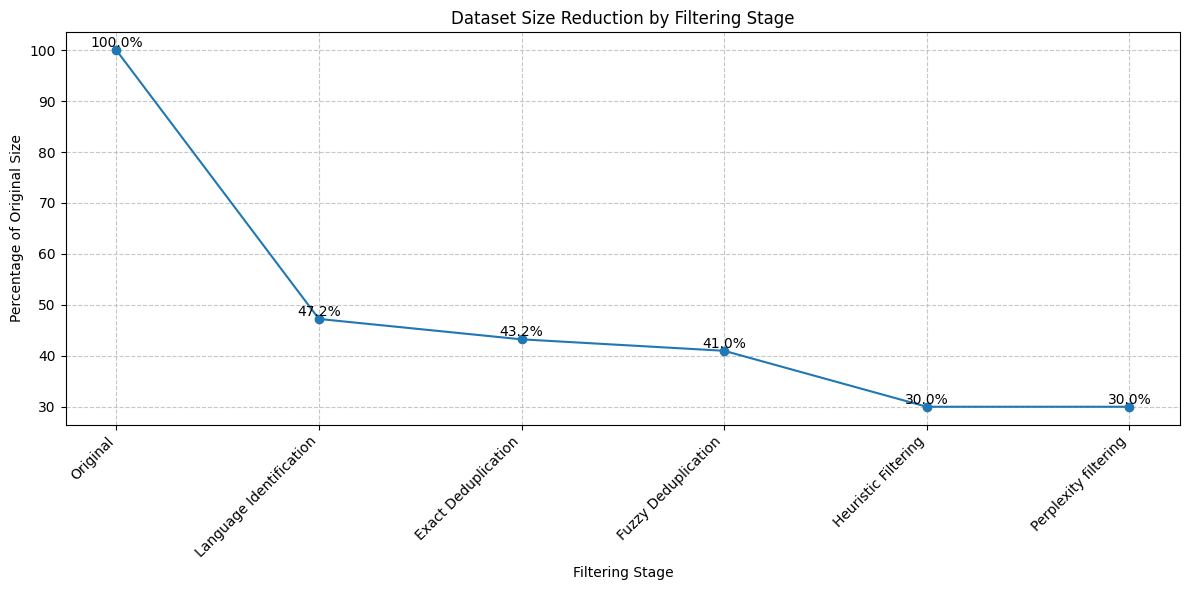

In [28]:
tracker.plot_size_reduction()

### 2.5 Model based quality labeling

Now, we will assess the quality of each document using a model-based quality labeling approach. This involves classifying data into distinct quality buckets based on an ensemble of scores from several language models: [FineWebMixtralEduClassifier](https://huggingface.co/nvidia/nemocurator-fineweb-mixtral-edu-classifier), [FineWebNemotronEduClassifier](https://huggingface.co/nvidia/nemocurator-fineweb-nemotron-4-edu-classifier), and [fasttext-oh-eli5](https://huggingface.co/mlfoundations/fasttext-oh-eli5).
 
Much of the code in this section is adapted from this tutorial: [Ensembling FineWeb Mixtral Educational Classifier, FineWeb Nemotron-4 Educational Classifier, and fasttext-oh-eli5](https://github.com/NVIDIA/NeMo-Curator/blob/main/tutorials/distributed_data_classification/fineweb-edu-ensemble-classification.ipynb). Refer to that notebook for a more detailed explanation of the process.

#### 2.5.1 Quality classification

In [5]:
from nemo_curator.classifiers import FineWebNemotronEduClassifier, FineWebMixtralEduClassifier
from nemo_curator.utils.distributed_utils import load_object_on_worker
from nemo_curator.utils.distributed_utils import get_device_total_memory
from fast_text_classifier import FastTextQualityClassifier

In [6]:
import json
import fasttext
import pandas as pd
import cudf
import dask_cudf
import numpy as np
import cupy as cp
from pathlib import Path
from typing import Optional, Tuple, Any, Dict, List
from huggingface_hub import hf_hub_download

from nemo_curator import get_client
from nemo_curator.classifiers import FineWebNemotronEduClassifier, FineWebMixtralEduClassifier
from nemo_curator.datasets import DocumentDataset
from nemo_curator.utils.distributed_utils import load_object_on_worker
from nemo_curator.utils.distributed_utils import get_device_total_memory

In [ ]:
client = get_client(cluster_type="gpu")
client

cuDF Spilling is enabled


In [34]:
quality_labeling_output_data_dir = os.path.join(data_dir,"quality_labeling")
quality_classification_results_dir = os.path.join(quality_labeling_output_data_dir, "classification_results.parquet")
quality_classifcation_thresholds_dir = os.path.join(quality_labeling_output_data_dir, "classifier_thresholds.json")
output_bucketed_results = os.path.join(quality_labeling_output_data_dir, "bucketed_results")

!mkdir -p {quality_labeling_output_data_dir}
!mkdir -p {output_bucketed_results}

In [9]:
# Define classifier score mapping
classifier_scores = {
    "nemotron-score": {
        "int_score": "fineweb-nemotron-edu-score-int",
        "float_score": "fineweb-nemotron-edu-score"
    },
    "mixtral-score": {
        "int_score": "fineweb-mixtral-edu-score-int",
        "float_score": "fineweb-mixtral-edu-score"
    },
    "fasttext-score": {
        "int_score": "fasttext-quality-score-int",
        "float_score": "fasttext-quality-score"
    }
}



# Initialize classifiers
classifiers = [
    FineWebNemotronEduClassifier(batch_size=1024,
                         pred_column=classifier_scores["nemotron-score"]["float_score"],
                         int_column=classifier_scores["nemotron-score"]["int_score"]),
    FineWebMixtralEduClassifier(batch_size=1024,
                         pred_column=classifier_scores["mixtral-score"]["float_score"],
                         int_column=classifier_scores["mixtral-score"]["int_score"]),
    FastTextQualityClassifier(pred_column=classifier_scores["fasttext-score"]["float_score"],
                         int_column=classifier_scores["fasttext-score"]["int_score"])
]

In [ ]:
input_dataset = DocumentDataset.read_parquet("/workspace/nemotron-cc/data/perplexity_filtering/data/hq.parquet/result.parquet", backend="cudf")

In [11]:
output_dataset = input_dataset
for classifier in classifiers:
    output_dataset = classifier(dataset=output_dataset)

# Dropping int columns
# As we add new based on a threshold (in the following columns)
output_dataset = output_dataset.df.drop(columns=[v["int_score"] for v in classifier_scores.values()]).compute()


Starting FineWeb Nemotron-4 Edu Classifier inference


Starting FineWeb Mixtral Edu Classifier inference


GPU: tcp://127.0.0.1:34197, Part: 0:   0%|          | 0/47107 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/crossfit/backend/torch/loader.py:184: UserWarning: Not enough memory for a batch size of 8192. Retrying with a new batch size of 4096. Consider setting initial batch size to 4096.
  warnings.warn(
GPU: tcp://127.0.0.1:34197, Part: 0:   0%|          | 0/47107 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/crossfit/backend/torch/loader.py:184: UserWarning: Not enough memory for a batch size of 8192. Retrying with a new batch size of 4096. Consider setting initial batch size to 4096.
  warnings.warn(
GPU: tcp://127.0.0.1:34197, Part: 0: 100%|██████████| 47107/47107 [00:33<00:00, 1423.92it/s]


In [28]:
client.cluster.close()
client.shutdown()

In [ ]:
output_dataset.head()

In [35]:
output_dataset.to_parquet(path=quality_classification_results_dir)

get_mempolicy: Operation not permitted


In [36]:
del classifiers, output_dataset, input_dataset

#### 2.5.2 Process scores

In [ ]:
scored_data = DocumentDataset.read_parquet(quality_classification_results_dir, backend="cudf")

In [ ]:
# Compute thresholds
from quality_labeling_utlities import compute_thresholds_for_score_columns, save_thresholds, map_score_columns

# Adjust fraction based on how much can fit in a single GPU (1/2 ish)
gpu_memory_available = get_device_total_memory()/2
frac = max(1, scored_data.df.memory_usage(deep=True).sum().compute()/gpu_memory_available)
sampled_data =  scored_data.df.sample(frac=frac).repartition(npartitions=1)

score_col_names = [v["float_score"] for v in classifier_scores.values()]
threshold_dict = sampled_data.map_partitions(compute_thresholds_for_score_columns, text_col_name="text", score_col_names=score_col_names).compute().iloc[0]
save_thresholds(threshold_dict, quality_classifcation_thresholds_dir)

scored_data.df = scored_data.df.map_partitions(map_score_columns, score_col_names, threshold_dict)

In [41]:
# Compute final ensembled score
int_column_names = [f"{v["float_score"]}-int" for v in classifier_scores.values()]
scored_data.df["ensemble-max-int"] = scored_data.df[int_column_names].max(axis=1)

In [42]:
scored_data.df.head()

,fasttext-quality-score,fineweb-mixtral-edu-score,fineweb-mixtral-edu-score-label,fineweb-nemotron-edu-score,fineweb-nemotron-edu-score-label,id,language,source_id,text,url,warc_id,fineweb-nemotron-edu-score-int,fineweb-mixtral-edu-score-int,fasttext-quality-score-int,ensemble-max-int
0,0.000809,0.959473,low_quality,1.218750,low_quality,EN_CC-0000000000,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Media coverage\n\nParallels Coming to the 2014...,http://028zq.com/news/shownews.php?id=16&lang=en,deee4ce0-c404-4ff3-8700-0b45e8ac6b5e,8,7,3,8
1,0.022132,2.468750,low_quality,2.587891,high_quality,EN_CC-0000000001,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,techspace-skywatch\n\nA network of Autonomous ...,http://2014.spaceappschallenge.org/project/tec...,6c17be7f-7253-4703-aead-0aa6e53bcb5d,18,17,12,18
2,0.000411,0.722656,low_quality,0.885254,low_quality,EN_CC-0000000002,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,lemon rosemary chicken\n\nLeave a Reply\n\nJoi...,http://400caloriesorless.com/?attachment_id=3867,f70dc315-8ee5-4cd1-b685-975f36f15e90,5,5,2,5
3,0.002615,0.399170,low_quality,0.780273,low_quality,EN_CC-0000000004,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Teen Patti Master – Update APK Download & Get ...,http://789mgmslots.com/2024/08/26/teen-patti-m...,48640b9c-d821-4c3a-bf31-a16e3eb30f0f,4,3,6,6
4,0.001981,0.218994,low_quality,0.188599,low_quality,EN_CC-0000000005,EN,crawl-data-CC-MAIN-2024-51-segments-1733066035...,Lump sum payment specialists since 1992\n\nFor...,http://GRANOFFENTERPRISES.COM/,da02f4d5-57bb-4dde-9089-cacb273d2362,1,2,5,5


#### [Optional] Write results to partitioned buckets

Organize and store classified results in a structured, partitioned format to facilitate annealing-based training for downstream LLM fine-tuning and optimization.

In [ ]:
scored_data.to_parquet(output_bucketed_results, partition_on="ensemble-max-int")
all_buckets = sorted(os.listdir(output_bucketed_results))

Examining the distribution of data across buckets reveals a relatively even spread. This indicates our filtering process has generated a diverse dataset with a broad spectrum of content quality.

Number of entries in each bucket (sorted by bucket number):
ensemble-max-int=0: 658
ensemble-max-int=1: 1588
ensemble-max-int=2: 1848
ensemble-max-int=3: 2037
ensemble-max-int=4: 2044
ensemble-max-int=5: 2170
ensemble-max-int=6: 2171
ensemble-max-int=7: 2241
ensemble-max-int=8: 2328
ensemble-max-int=9: 2340
ensemble-max-int=10: 2438
ensemble-max-int=11: 2248
ensemble-max-int=12: 2510
ensemble-max-int=13: 2627
ensemble-max-int=14: 2553
ensemble-max-int=15: 2598
ensemble-max-int=16: 2703
ensemble-max-int=17: 2873
ensemble-max-int=18: 3208
ensemble-max-int=19: 3924


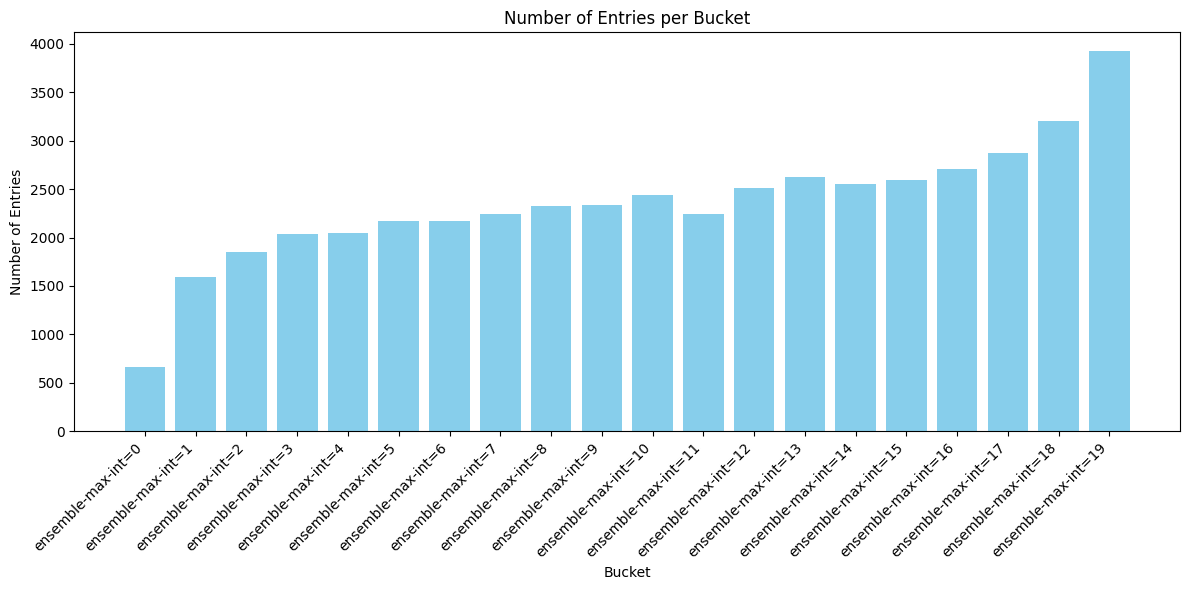

In [13]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

bucket_counts = {}
for bucket in sorted(os.listdir(output_bucketed_results)):
    bucket_path = os.path.join(output_bucketed_results, bucket)
    parquet_files = glob.glob(os.path.join(bucket_path, "*.parquet"))
    
    count = 0
    for file in parquet_files:
        try:
            df = pd.read_parquet(file)
            count += len(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    bucket_counts[bucket] = count

# Sort buckets based on the integer value of the last character
sorted_buckets = sorted(bucket_counts.keys(), key=lambda x: int(x.split("=")[-1]))

print("Number of entries in each bucket (sorted by bucket number):")
for bucket in sorted_buckets:
    print(f"{bucket}: {bucket_counts[bucket]}")

# Create a bar plot of bucket counts, using the sorted bucket order
plt.figure(figsize=(12, 6))
buckets = sorted_buckets
counts = [bucket_counts[bucket] for bucket in sorted_buckets]

plt.bar(buckets, counts, color="skyblue")
plt.xlabel("Bucket")
plt.ylabel("Number of Entries")
plt.title("Number of Entries per Bucket")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

This step labels the data with quality scores but does not alter the dataset size through filtering.

In [ ]:
tracker.record_size("Model quality labeling") # tracker takes the last stage's size as current stage's size when no size is provided.
tracker.print_summary()

## 3. Synthetic Data Generation

Next, we perform synthetic data generation on low-quality and high-quality data separately. 

For low-quality data, we use a Wikipedia Rephraser pipeline. This pipeline employs a medium-sized language model to generate an improved parallel corpus of synthetic data, which reduces model perplexity and increases accuracy on downstream tasks. We use the Wikipedia style prompt to rewrite low-quality documents, effectively reducing errors and redundancies while improving formatting.

#### 3.1 Separating Data into Low and High Quality Buckets

To streamline the process of identifying low-quality data, we adopt the bucket classification system outlined in the paper, eliminating the need for extensive LLM training. Based on the provided table, we designate buckets 0-11 as representative of low-quality data and buckets 12-19 as indicative of high-quality data. Feel free to adjust these ranges to suit your specific requirements.

<div style="text-align: center;">
<img src="images/bucket_classification.png" alt="Bucket Classification" width="400">
</div>

In [4]:
# Choose your bucket threshold
threshold = 11

input_data_dir = os.path.join(data_dir, "quality_labeling", "bucketed_results")
low_quality_data_dir = os.path.join(data_dir, "quality_labeling", "low_quality")
high_quality_data_dir = os.path.join(data_dir, "quality_labeling", "high_quality")

os.makedirs(low_quality_data_dir, exist_ok=True)
os.makedirs(high_quality_data_dir, exist_ok=True)

import re
import shutil

for f in os.listdir(input_data_dir):
    input_bucket_dir = os.path.join(input_data_dir, f)
    if os.path.isdir(input_bucket_dir):
        match = re.search(r"(\d+)$", f)  # Extract trailing digits
        if match:
            bucket_number = int(match.group(1))  # Convert to integer
            if 0 <= bucket_number <= threshold:
                shutil.copytree(input_bucket_dir, low_quality_data_dir, dirs_exist_ok=True)
            elif 12 <= bucket_number <= 19:
                shutil.copytree(input_bucket_dir, high_quality_data_dir, dirs_exist_ok=True)
            else:
                print(f"Warning: Unexpected bucket number: {bucket_number} in directory {f}. Skipping.")
        else:
            print(f"Warning: Unexpected file/directory name format: {f}. Skipping.")

In [ ]:
client = get_client(cluster_type="cpu", n_workers=1, processes=True, memory_limit="16GiB")
client

In [6]:
low_quality_data_dir = os.path.join(data_dir, "quality_labeling", "low_quality")
high_quality_data_dir = os.path.join(data_dir, "quality_labeling", "high_quality")
low_quality_output_data_dir = os.path.join(data_dir, "sdg", "low_quality")
high_quality_output_data_dir = os.path.join(data_dir, "sdg", "high_quality")
!mkdir -p {low_quality_output_data_dir}
!mkdir -p {high_quality_output_data_dir}

In [5]:
from openai import AsyncOpenAI, OpenAI
from transformers import AutoTokenizer

openai_api_token = "<your-openai-api-token>"
hf_token = "<your-huggingface-token>"
hf_model_name = "google/gemma-3-1b-it"
api_model_name = "google/gemma-3-1b-it"
base_url = "https://integrate.api.nvidia.com/v1"


tokenizer = AutoTokenizer.from_pretrained(hf_model_name, token=hf_token)
openai_client = OpenAI(base_url=base_url, api_key=openai_api_token)

In [7]:
# Test client
response = openai_client.chat.completions.create(
    model=api_model_name,
    messages=[{"role": "user", "content": "Hello, how are you?"}],
    max_tokens=10
)
print("Client test successful!")
print("Response:", response.choices[0].message.content)

Client test successful!
Response: I am doing well, thank you for asking!


#### 3.1 SDG for Low quality data

In [9]:
# Load the original data with pandas
low_quality_df = pd.read_parquet(os.path.join(low_quality_data_dir))
print("Original Length:", len(low_quality_df))

# Take a sample for processing
x = 0.0005  # 0.01% of the dataset
sample_indices = low_quality_df.sample(frac=x).index
sample_df = low_quality_df.loc[sample_indices].copy()
print("Small dataset length:", len(sample_df))

# Create DocumentDataset from the sample
low_quality_sample_dataset = DocumentDataset.from_pandas(sample_df)

Original Length: 24111
Small dataset length: 12


In [10]:
from nemotron_sdg_utilities import wikipedia_rephraser

rephrased_dataset = wikipedia_rephraser(low_quality_sample_dataset, "text", openai_client, tokenizer, api_model_name)

Running Wikipedia rephraser preprocessing pipeline
Taking out a small portion of the input dataset to save time.


Rephrasing texts..:   0%|          | 0/22 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Rephrasing texts..: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]


Running Wikipedia rephraser postprocessing pipeline
Wikipedia rephraser postprocessing complete.


In [20]:
rephrased_df = rephrased_dataset.df.compute()
# Merge new columns from processed samples into high quality dataframe using pd.merge
merged_df = pd.merge(
    low_quality_df,
    rephrased_df[["id", "rephrased"]],
    on="id",
    how="left"
)

In [21]:
visualize_df = merged_df[merged_df["id"].isin(rephrased_df["id"])][["id", "text", "rephrased"]]
visualize_df.head()

,id,text,rephrased
5635,EN_CC-0000013680,CONCEPT\n\nDESIGN\n\nEXECUTION\n\nDouble Wall ...,"The process of designing, constructing, and pr..."
6629,EN_CC-0000060037,Marble Swirl Painted Pouch\n\nThis item is a r...,The “Marble Swirl Painted Pouch” is a product ...
9249,EN_CC-0000017270,Will Need to Have Resources For Online Casino\...,The availability of robust financial infrastru...
9350,EN_CC-0000020173,Purple Wedding Attire + Outfit Ideas\n\nPurple...,The prompt explores various options for attire...
10088,EN_CC-0000046958,"Asphalt Services in Highland, Texas\n\nKeen Pa...","Keen Painting & Renovations in Highland, Texas..."


In [26]:
merged_df.to_parquet(os.path.join(low_quality_output_data_dir,"result.parquet"))

In [17]:
client.cluster.close()
client.shutdown()

#### 3.2 SDG for High quality data

For high-quality documents, we generate synthetic data using four additional SDG steps:

1.  **Diverse Question-Answer (QA) pairs:** Ask questions in various forms (e.g., yes/no, open-ended, multi-choice) about factual information in the text and provide the correct answers.
2.  **Distill:** Rewrite the text into a concise and clear passage.
3.  **Extract knowledge:** Rewrite knowledge from the text, disregarding uninformative content.
4.  **Knowledge list:** Extract key information from the text as an organized list.

The preprocessing and postprocessing pipelines for all four SDG steps are implemented as helper functions in `nemotron_sdg_utilities.py`. Review this file to understand how the pipelines are constructed using NeMo Curator.

The Wikipedia rephraser calls the model via the OpenAI API client for every single entry, which can be time-consuming for large datasets. 
For this tutorial, we will only rephrase the first few entries, as determined by `n_entries`. 
Adjust this number based on your infrastructure. 
If your model is deployed locally then API calls will be faster, so you can choose to process the entire dataset if you prefer.

In [ ]:
# Load the original data with pandas
high_quality_df = pd.read_parquet(os.path.join(high_quality_data_dir))
print("Original Length:", len(high_quality_df))

# Take a sample for processing
x = 0.0001  # 0.01% of the dataset
sample_indices = high_quality_df.sample(frac=x).index
sample_df = high_quality_df.loc[sample_indices].copy()
print("Small dataset length:", len(sample_df))

# Create DocumentDataset from the sample
high_quality_sample_dataset = DocumentDataset.from_pandas(sample_df)

In [9]:
from nemotron_sdg_utilities import generate_content

high_quality_sample_dataset = generate_content(
    high_quality_sample_dataset,
    "text",
    openai_client,
    tokenizer,
    api_model_name, 
    task_type="diverse_qa"
)

high_quality_sample_dataset = generate_content(
    high_quality_sample_dataset,
    "text",
    openai_client,
    tokenizer,
    api_model_name, 
    task_type="distill"
)

high_quality_sample_dataset = generate_content(
    high_quality_sample_dataset,
    "text",
    openai_client,
    tokenizer,
    api_model_name, 
    task_type="extract_knowledge"
)

high_quality_sample_dataset = generate_content(
    high_quality_sample_dataset,
    "text",
    openai_client,
    tokenizer,
    api_model_name, 
    task_type="knowledge_list"
)

processed_sample_df = high_quality_sample_dataset.df.compute()

Running diverse_qa preprocessing pipeline


Querying LLM for diverse_qa:   0%|          | 0/3 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM for diverse_qa: 100%|██████████| 3/3 [00:18<00:00,  6.33s/it]


diverse_qa generation complete.
Running distill preprocessing pipeline


Querying LLM for distill:   0%|          | 0/2 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM for distill: 100%|██████████| 2/2 [00:14<00:00,  7.40s/it]


distill generation complete.
Running extract_knowledge preprocessing pipeline


Querying LLM for extract_knowledge:   0%|          | 0/2 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM for extract_knowledge: 100%|██████████| 2/2 [00:19<00:00,  9.57s/it]


extract_knowledge generation complete.
Running knowledge_list preprocessing pipeline


Querying LLM for knowledge_list:   0%|          | 0/2 [00:00<?, ?it/s]/opt/NeMo-Curator/nemo_curator/services/openai_client.py:52: UserWarning: top_k is not used in an OpenAIClient
  warnings.warn("top_k is not used in an OpenAIClient")
Querying LLM for knowledge_list: 100%|██████████| 2/2 [00:15<00:00,  7.52s/it]


knowledge_list generation complete.


Since we're working with a small sample dataset, we need to merge it back with the full dataset before saving.
Note: This merge step would be unnecessary if processing the complete dataset.

In [111]:
# Merge new columns from processed samples into high quality dataframe using pd.merge
merged_df = pd.merge(
    high_quality_df,
    processed_sample_df[["id", "diverse_qa", "distill", "extract_knowledge", "knowledge_list"]],
    on="id",
    how="left"
)

In [112]:
merged_df.to_parquet(os.path.join(high_quality_output_data_dir,"result.parquet"))

## 4. Dataset compilation

Merge the synthetically generated datasets into a unified dataset for downstream tasks, ensuring proper quality labels and column selection.

In [27]:
high_quality_df = pd.read_parquet(os.path.join(data_dir,"sdg","high_quality", "result.parquet"))
low_quality_df = pd.read_parquet(os.path.join(data_dir,"sdg","low_quality", "result.parquet"))

# Add quality column to both dataframes
high_quality_df["quality"] = "HIGH"
low_quality_df["quality"] = "LOW"

# Concatenate vertically
final_df = pd.concat([high_quality_df, low_quality_df], axis=0, ignore_index=True)

In [28]:
for col in final_df.columns:
    print(col)

fasttext-quality-score
fineweb-mixtral-edu-score
fineweb-mixtral-edu-score-label
fineweb-nemotron-edu-score
fineweb-nemotron-edu-score-label
id
language
source_id
text
url
warc_id
fineweb-nemotron-edu-score-int
fineweb-mixtral-edu-score-int
fasttext-quality-score-int
diverse_qa
distill
extract_knowledge
knowledge_list
quality
rephrased


We need to filter the final dataset to keep only the most important columns that will be used in downstream tasks, removing any unnecessary metadata or intermediate processing columns.

In [ ]:
!mkdir -p {data_dir}/final
final_df[["id","text","language","rephrased","diverse_qa","distill","extract_knowledge","knowledge_list","quality"]].to_json(os.path.join(data_dir,"final","final_dataset.jsonl"), orient="records", lines=True)

In [ ]:
final = pd.read_json(os.path.join(data_dir,"final","final_dataset.jsonl"), orient="records", lines=True)

## 5. Visualization

Use the helper utility to visualize the text transformation between original and rephrased content during the Synthetic Data Generation (SDG) process, comparing low and high quality examples.

In [8]:
import pandas as pd
import os
data_dir = os.path.join(os.path.dirname(os.getcwd()), "nemotron-cc", "data")
data_dir

'/Users/vikalluru/Documents/NeMo-Curator/tutorials/nemotron-cc/data'

In [10]:
from viz.text_comparison_widget import compare_row_by_id

low_quality_exmaple = "EN_CC-0000000181"

compare_row_by_id(
    final,                          
    row_id=low_quality_exmaple,   # Change the row id to see different examples
    id_column="id",               
    col1="text",                 
    col2="rephrased",            
    title1="Original",            
    title2='Rephrased with Wikipedia rephraser',
    max_height="800px",
    width="100%",
)

Id,Original,Rephrased with Wikipedia rephraser
EN_CC-0000000181,"OMG!!! I am so so so so so made up to see that this plugin is not dead!! I love MEXP, and was just about to retire it due to sound skipping on very old version, which I believe to be a problem with new version of winamp and old ver of mexp and sqrsoft crossfader, is anyone else having this issue? please put me out of my misery, i have tried everything to find out what is wrong, replacing fans, memory hard drives and even gonna try laptop, mail me on my website http://www.ctadisco.co.uk – this program is the GOD and i have never found any program since to replace it!! – so glad to have you back regards Will – CTA Disco & Karaoke Anders – you said you'd upload a new version in August. Nothing yet. I know you're really busy so I don't feel right about pressuring you, but it was so good to see the MEXP ball rolling again after so many years of nothing! Has anyone being working on the open source project? And can you upload the new version soon? Thanks!","<div class=""text-cell"" data-column=""rephrased"" data-all-columns=""{""rephrased"": ""Oh, what a relief! I'm thrilled to discover that this plugin is still alive and kicking! I'm a huge fan of MEXP, but I was on the verge of abandoning it due to persistent sound skipping issues on older versions. I suspect this might be due to compatibility issues with newer versions of Winamp and the outdated MEXP and Sqrsoft Crossfader. I'm not alone in this struggle, am I? I've exhausted all troubleshooting efforts, from replacing hardware components to contemplating a laptop switch. If anyone has insights, please share. You can reach me via my website, http://www.ctadisco.co.uk. This software is truly unparalleled, and I've yet to find a suitable replacement. Here's to a new beginning, regards, Will \u2013 CTA Disco & Karaoke.\n\nAnders, you had mentioned an August upload for a new version. It's been a while, and I understand that you're incredibly busy. I wouldn't dream of rushing you, but it was such a joy to see MEXP's revival after years of inactivity. Has anyone been working on the open-source project? I eagerly await the new version's release. Thank you!""}"">Oh, what a relief! I'm thrilled to discover that this plugin is still alive and kicking! I'm a huge fan of MEXP, but I was on the verge of abandoning it due to persistent sound skipping issues on older versions. I suspect this might be due to compatibility issues with newer versions of Winamp and the outdated MEXP and Sqrsoft Crossfader. I'm not alone in this struggle, am I? I've exhausted all troubleshooting efforts, from replacing hardware components to contemplating a laptop switch. If anyone has insights, please share. You can reach me via my website, http://www.ctadisco.co.uk. This software is truly unparalleled, and I've yet to find a suitable replacement. Here's to a new beginning, regards, Will – CTA Disco & Karaoke. Anders, you had mentioned an August upload for a new version. It's been a while, and I understand that you're incredibly busy. I wouldn't dream of rushing you, but it was such a joy to see MEXP's revival after years of inactivity. Has anyone been working on the open-source project? I eagerly await the new version's release. Thank you!"


In [16]:
from viz.text_comparison_widget import compare_row_by_id

high_quality_exmaple = "EN_CC-0000031171"

method = "distill" # Choose between diverse_qa, distill, extract_knowledge, knowledge_list
compare_row_by_id(
    final,
    row_id=high_quality_exmaple,    # Change the row id to see different examples
    id_column="id",               
    col1="text",                  
    col2=method,
    title1="Original",
    max_height="800px",
    width="100%"
)

Id,Original,Distill
EN_CC-0000031171,"In this section Shellstock Shipper General Requirements Shellfish are a perishable food product that must be handled and processed under sanitary conditions with proper temperature control to avoid contamination and excessive bacterial growth. Operators must be aware of detailed information contained in both Chapter 246-282 WAC and Chapter 69.30 RCW, sanitary control of shellfish. The following information is provided to assist you in complying with WAC 246-282. These basic requirements are necessary to maintain your Shellfish Operation License and Certificate of Approval. Harvest Sites All commercial harvest sites must be approved by this Office prior to being harvested. Washing Shellstock Shellfish must be washed so that they are reasonably free of mud prior to shipment. Approved growing area water or other water systems approved by this Office may be used. The primary responsibility for washing shellstock is with the harvester. Safety of Water If the water supply is from a private source (well), the Harvester shall make arrangements to have the water supply tested for bacteriological contamination at laboratories sanctioned or certified by the Authority. This shall be done prior to use and every six months thereafter while the water supply is in use. Copies of official test results must be kept on record. Included for your use is a form to keep track of test dates and test results. Shipping Shellstock Trucks or other conveyances used in transporting shellstock must be maintained in a clean and sanitary condition. Clean pallets shall be utilized if the vehicle does not have a channeled floor. Temperature Control During May through September, Harvesters will be in accordance with the Vibrio parahaemolyticus control plan, WAC 246-282-006. During October through April, Harvesters will harvest in accordance with the Time to Temperature Controls listed in the NSSP, Chapter VIII @.02 A. (3). Tags All containers of shellfish must be identified with a durable, waterproof tag or label containing the following information: Dealer's name and address. Dealer's certification number. Date of harvest. Harvest location (including ""WA""). Type and quantity of shellfish. Bold statement in caps: THIS TAG IS REQUIRED TO BE ATTACHED UNTIL CONTAINER IS EMPTY OR IS RETAGGED AND THEREAFTER KEPT ON FILE, IN CHRONOLOGICAL ORDER, FOR 90 DAYS. RETAILERS: DATE WHEN LAST SHELLFISH FROM THIS CONTAINER SOLD OR SERVED (INSERT DATE). Statement on the back of each tag must read: Consuming raw or undercooked meats, poultry, seafood, shellfish, or eggs may increase your risk of foodborne illness, especially if you have certain medical conditions. The statement ""Keep Refrigerated"" or an equivalent statement must be included on the tag. Note: Bulk shipments must be accompanied by a transaction record containing the same information. Additionally, the single bulk tag used to represent the bulk lot shall also include the following statement: ""All shellstock containers in this lot have the same harvest date and area of harvest"" along with the number of individual containers in the unit. Recordkeeping You must have a bound book for your record keeping system which is maintained for three years. Your record keeping system must show the following:","<div class=""text-cell"" data-column=""distill"" data-all-columns=""{""distill"": ""Tagging Requirements:\n- Tags must warn: \""Consuming raw/undercooked meats, poultry, seafood, shellfish, or eggs may increase foodborne illness risk, especially with certain medical conditions.\""\n- Include \""Keep Refrigerated\"" or equivalent.\n- Bulk shipments need a transaction record and tag stating: \""All shellstock containers in this lot have the same harvest date and area. [Number of containers]\""\n\nRecordkeeping:\n- Maintain a bound book for three years, showing:\n - Shellstock Shipper General Requirements:\n - Shellfish must be handled, processed, and transported under sanitary condit

We've now completed our exploration of the Nemotron-CC data curation pipeline. Through this tutorial, we've demonstrated how to download and process public data, remove duplicates, evaluate quality metrics, and enrich the dataset with synthetic content to produce an optimized long-horizon pretraining corpus. Our approach advances the state-of-the-art by achieving an improved balance between model performance and dataset size. We've used visualization tools throughout to examine the impact of each pipeline stage. The final curated dataset is ready for use in training large language models and other downstream applications.